# Variable Length Motif Discovery for User Interaction Logs

Enhancing the publication of Hohenadl to reduce the dependency on window size

In [17]:
import sys
sys.path.append('../') # To import from parent dir
import os

import time

import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import math

import util.GrammarBasedUtil as grammar_util
import util.valmod_uihe as valmod_util
from util.util import encoding_UiLog, read_data_for_processing, print_progress_bar

from experiment import run_experiment

import matplotlib as plt
import matplotlib.pyplot as plt

from itertools import chain

# LOCOmotif multi variate variable length motif discovery
# Source: https://github.com/ML-KULeuven/locomotif/tree/main
# Paper:  https://link.springer.com/article/10.1007/s10618-024-01032-z
import locomotif.locomotif as locomotif 
import util.locomotif_vis as visualize


import warnings
# Example: Only show a warning once globally
warnings.filterwarnings('ignore', category=UserWarning)

# EX1 Setup

To run the EX1 from the paper do the following:
1. Select, which log you want to run (SRRT+, SRRT||, SRRT+ext, SRRT||ext)
2. Put the log name and ground truth name as **leno_file_name** and **leno_gt_file_name**
3. If required/wanted, adjust the **rho_LoCoMotif** parameter. Recommendation is to set it to 0.7
4. Run all cells from here 

The cells directly below are for configuration purpose. If you want to run your own log please go to the Jupyter Notebook 01x_Log_Discovery

In [18]:
# ---- Leno Sequential Log ----
# Possible Leno Combinations are
# >> No Inter-Motif Noise
# 202511_SR_RT_plus.csv & 202511_SR_RT_plus_ground_truth.csv
# 202511_SR_RT_parallel.csv & 202511_SR_RT_parallel_ground_truth.csv

# >> 50 Motifs of varied length with intra motif noise
# 202511_SR_RT_plus_extended.csv & 202511_SR_RT_plus_extended_ground_truth.csv 
# 202511_SR_RT_parallel_extended.csv & 202511_SR_RT_parallel_extended_ground_truth.csv
isActionLogger = True
leno_file_name = "202511_SR_RT_plus_extended.csv"
leno_gt_file_name = "202511_SR_RT_plus_extended_ground_truth.csv"

# ---- Generic Parameters that were tested in other publications ----
rho_LoCoMotif = 0.7 # Rho parameter for LoCoMotif variable length motif discovery

# Configuration of Parameters for discovery

Set the following parameters to test our approach in different scenarions.
You can choos to set:

- **isSmartRPA** to **TRUE** if you want a smartRPA example log to be processed.
- **log_name_smartRPA** to **[LOGNAME]** if you want a specific log to be processed. If no log is entered the default is **LenLog_1_1_10_25_5_5000.csv**

- **isActionLogger** to **TRUE** if you want one of the Leno et al. logs to be processed.
- **leno_plus** to **TRUE** if you want the log first containing all student record routines before all reimbursement routines, if set to **FALSE** the student records and reimbursement routines alternate

- **isRealWorldTest** to **TRUE** if you want to test the approach on a small, real-world data set.

- **isHCI** to **TRUE** if you want a human-computer interaction log as a test sample. Please note: This log has only few attributes compared to a UI log and thus does not work properly. Furthermore it only contains routine executions and no inter-routine noise.

**PLEASE NOTE** The first **TRUE** value will be processed. If you want to have one of the later values to be processed, you have to set all previous values (expect leno_plus) to **FALSE**

#### About the data

Depending on the selection before of the parameters of this notebook, the code prepares the data to make the notebook run smooth.
If a new log should be process-able, the preprocessing has to be added in the **util.util.read_data_for_processing** function.

The following data is prepared for processing:
1. The context parameter levels according to the UI hierarchy reference model
   1. Each hierarchy level as an individual list
   2. hierarchy_list: A list of lists
   3. hierarchy_columns: A flattend (concatenated) list of the context parameters
2. The Ground Truth for Experiment comparison (Dataframe with columns: start_index, end_index, length)
3. CSV Read of the log(s)

#### Parameters

- **rule_density_threshold** is a threshold for Rule Density in Re-Pair. It increases the Grammar Rule Peak range by extending left and right until the rule count density drops below this threshold. E.g. setting the threshold at 0.8, if the rule-peak is at 10, the rules around this peak going to 8 or above will be included in the identified rule pattern.

- **stumpy_discovery_threshold** Threshold for STUMPY discovery as a true positiv when overlapping at least this much with a ground truth motif

- **app_switch_similarity_threshold** Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch

#### Dataset Sources:

**SmartRPA**
Source: https://zenodo.org/records/6518291
Creation of noisy data as defined in: 04_validationLogCreation.ipynb

**Leno**
Source: https://figshare.com/articles/dataset/UI_logs/12543587/4
Extension with noise from Hohenadl: https://link.springer.com/chapter/10.1007/978-3-032-02936-2_20

**Real World Log**
The real world log is a recording of one of the authors over multiple distributed periods of research. The authors have cleaned the log by removing all identifiers of the author, any passwords or account names.

**HCI**
Source: https://springernature.figshare.com/collections/A_dataset_of_human-machine_interactions_for_a_smarter_UX/6612805

Setup of Data and reading of necessary files for SmartRPA validation

-------------------------------------------

**Preperation Step**

Set the described parameters. After setting these according to your preference you can use **RUN ALL** in VS Code or similar methods in your IDE.

## Do Not change from here for **EX1** comparison

In [19]:
# Select the encoding method
# 1 - Word2Vec based encoding on context parameters
# 2 - Hierarchical encoding on context parameters
# 3 - Co-Occurrance Encoding
encoding_method = 1

# ---- Define if you want to process a sample Smart RPA Log ----
isSmartRPA2024 = False
# log_name_smartRPA = "LenLog_1_1_10_25_5_5000.csv" # 1 Routine Type, 10 Occurrances, 25 Routine Length, 5% of Log are Motifs
# log_name_smartRPA = "LenLog_1_10_1_10_5_1_5000.csv" # 1 Routine Type, 10 Intra-Routine Noise, 10 Occurances, 5 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_15_15_1_22500.csv" # 1 Routine Type, 20 Intra-Routine Noise, 15 Occurances, 15 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_15_25_1_37500.csv" # 1 Routine Type, 20 Intra-Routine Noise, 15 Occurances, 25 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_10_5_1_5000.csv"

# ---- Smart RPA New 2025 Validation Data for Var Length Motif Discovery ----
isSmartRPA2025 = False
log_name_smartRPA = "log_motifs5_occurances5_length20_percentage10_shuffle0.csv"

# ---- Real World Test Recording Author ----
isRealWorldTest = False

# ---- HCI Based Log ----

isHCI = False


rule_percentile_threshold = 0.90 # Percentile Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this percentile
rule_density_threshold = 0.8 # Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this threshold
app_switch_similarity_threshold = 0.75 # Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch
overlap_threshold = 0.8 # Threshold for considering a discovered motif as a true positive when overlapping at least this much with a ground truth motif >> Same as in Hohenadl 2025
safety_margin_factor = 2 # Factor to extend the safety margin around pattern switches detected in the grammar based analysis

**STEP 1: Grammar Based Core Detection** 

1. Read the data and gather the parameters for processing.
2. Generate Grammar
3. Generate Grammer Density Counts
4. Find Density Peaks and store as Grammar Based cores in "maximum_density_groups_df"

In [20]:
data_for_processing = read_data_for_processing(isSmartRPA2024=isSmartRPA2024,
                                               isSmartRPA2025=isSmartRPA2025,
                                                    isRealWorldTest=isRealWorldTest,
                                                    isActionLogger=isActionLogger,
                                                    leno_file_name=leno_file_name,
                                                    leno_gt_file_name=leno_gt_file_name,
                                                    isHCI=isHCI,
                                                    log_name_smartRPA=log_name_smartRPA,
                                                    encoding_method=encoding_method)

# Unpack the returned dictionary
hierarchy_list = data_for_processing["hierarchy_list"]
hierarchy_columns = data_for_processing["hierarchy_columns"]
hierarchy_columns_app_switch = data_for_processing["hierarchy_columns_app_switch"]
file = data_for_processing["file"]
log = data_for_processing["log"]
ground_truth = data_for_processing["ground_truth"]
# ui_log_encoded = data_for_processing["ui_log_encoded"]
# ground_truth_start_list = data_for_processing["ground_truth_start_list"]
column_identifier = data_for_processing["column_identifier"]

# Filter out hierarchy columns that have zero unique values
hierarchy_columns = [
    col for col in hierarchy_columns
    if log[col].nunique() != 0
]
tokens = 0
for col in hierarchy_columns:
    tokens += log[col].nunique()
token_based_vector_size = round(math.sqrt(tokens))

total_start_time = time.time()
# Apply the Grammar Based Rule Discovery and print a sample rule tree
encoding_df, symbols, two_gram_df = grammar_util.re_pair(log)
repair_time = time.time()
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Rule Entry: ",last_encoding)
# Just for visualization purposes
# decoded_symbol = grammar_util.re_pair_decode_symbol(last_encoding, encoding_df, printing=True)
log = grammar_util.generate_density_count(encoding_df, log)
density_count_time = time.time()

# Find the maximum density groups based on the rule density count
max_density_groups_from_rules, _ = grammar_util.find_max_density_groups(log,relative_threshold=rule_density_threshold,method="percentile",percentile_threshold=rule_percentile_threshold)
maximum_density_groups_df = pd.DataFrame(columns=["group","processed"])
maximum_density_groups_df["group"] = max_density_groups_from_rules

# Add start and end indices to the dataframe
maximum_density_groups_df["start_index"] = -1
maximum_density_groups_df["end_index"] = -1
maximum_density_groups_df["length"] = 0
for i, grammer_motif in maximum_density_groups_df.iterrows():
    maximum_density_groups_df.loc[i, "start_index"] = min(grammer_motif['group'])
    maximum_density_groups_df.loc[i, "end_index"] = max(grammer_motif['group'])
    maximum_density_groups_df.loc[i, "length"] = maximum_density_groups_df.loc[i, "end_index"] - maximum_density_groups_df.loc[i, "start_index"] + 1
    
start_indices = maximum_density_groups_df["start_index"].tolist()
end_indices = maximum_density_groups_df["end_index"].tolist()
max_density_groups_time = time.time()

Processing file: 202511_SR_RT_plus_extended.csv with 9646 events.
Using Word2Vec based encoding for UI Log

 Last Rule Entry:  mn


**Intermediary Visualisation** (Not Result Relevant)

Calculate the discovery scores for the grammar cores based on the ground truth.

Start Index of the first ground truth motif: 0
Maximum rule density count: 13
Longest identified motif length: 10


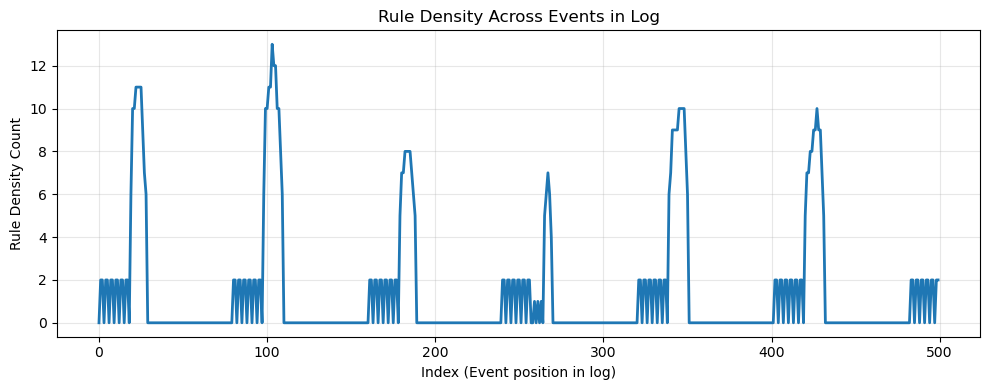

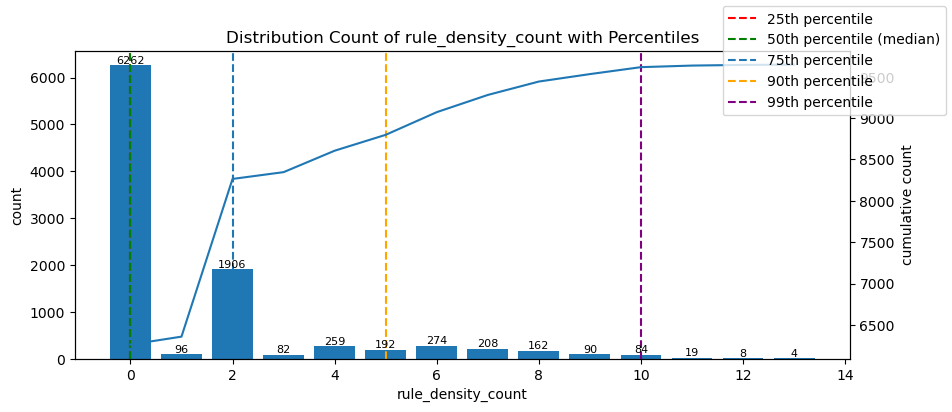

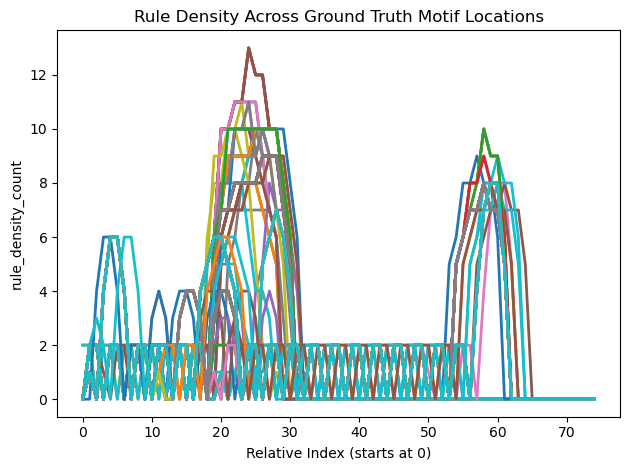

tp: 98.000
fp: 82.000
fn: 2.000
intersection_ratio: 1.000
intersection_abs: 5.783
undercount_ratio: 0.761
undercount_abs: 37.050
over_detection_ratio: 0.000
over_detection_abs: 0.000

Precision: 0.544, Recall: 0.980, F1: 0.700


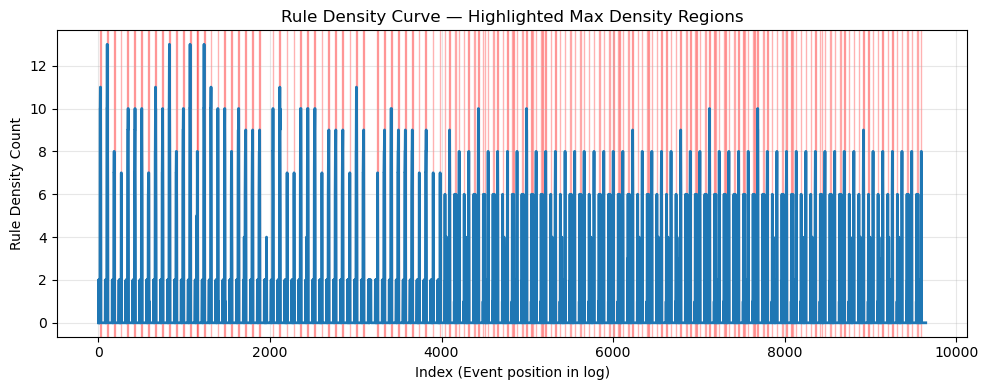

In [22]:
# ---- Visualisation Only ---- No Logic for subsequent processing ----
ground_truth.sort_values(by=["start_index"], inplace=True)
motiv = int(ground_truth.iloc[0]["start_index"])
print(f"Start Index of the first ground truth motif: {motiv}")
colors = plt.cm.tab10.colors
length = ground_truth["length"].max()
ground_truth = ground_truth.astype({'caseid': 'str', 'start_index': 'int', 'length': 'int', 'end_index': 'int'})

print(f"Maximum rule density count: {log['rule_density_count'].max()}")
max_length = -1
min_length = len(log)
for motif in maximum_density_groups_df["group"]:
    if len(motif) > max_length:
       max_length = len(motif)
       if len(motif) > 0 and len(motif) < min_length:
            min_length = len(motif)
            print(f"Longest identified motif length: {max_length}")
            
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
grammar_util.plot_rule_density_distribution(log, col_name="rule_density_count")

for i, start in enumerate(ground_truth["start_index"]):
    end = start+length+10
    y = log.iloc[int(start):int(end)]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")
    
plt.title("Rule Density Across Ground Truth Motif Locations") 
plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

# ---- Evaluate the discovered motifs against the ground truth ----
stats_new = grammar_util.evaluate_motifs(maximum_density_groups_df["group"], ground_truth, overlap_threshold)

overlap_table = stats_new["overlap_table"]         # DataFrame for inspection
tp, fp, fn = stats_new["tp"], stats_new["fp"], stats_new["fn"]
for key, value in stats_new.items():
    if key != "overlap_table" and key != "matched_pairs":
        print(f"{key}: {value:.3f}")

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# ---- Plotting the results ----
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_density_groups_from_rules:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**STEP 2: Context-Guided Log Reduction**

Identify app switches and filter the original log to rule-density based motif candidates

**STEP 3: Variable-Length Motif Discovery** 

Execute variable length motif discovery on the filtered log using LoCoMotif.

Total Included Range Length: 5457 of 9646
Percentage of Log Included: 56.57%
Using Word2Vec based encoding for UI Log
Parts of the log that are retained after filtering based on pattern switches and safety margins:


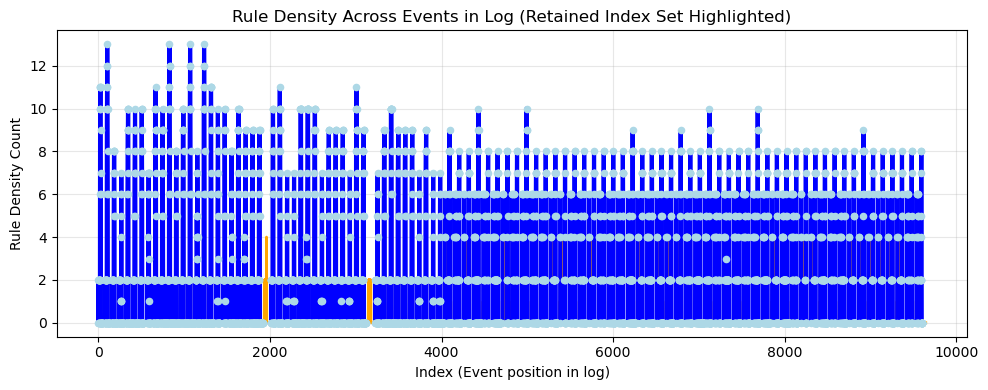

Rule Density Curve of first 500 Events before Filtering:


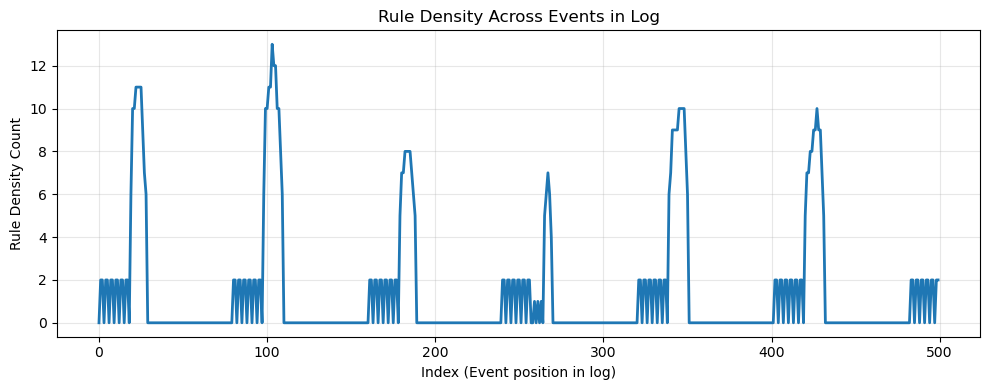

Rule Density Curve of first 500 Events after Filtering:


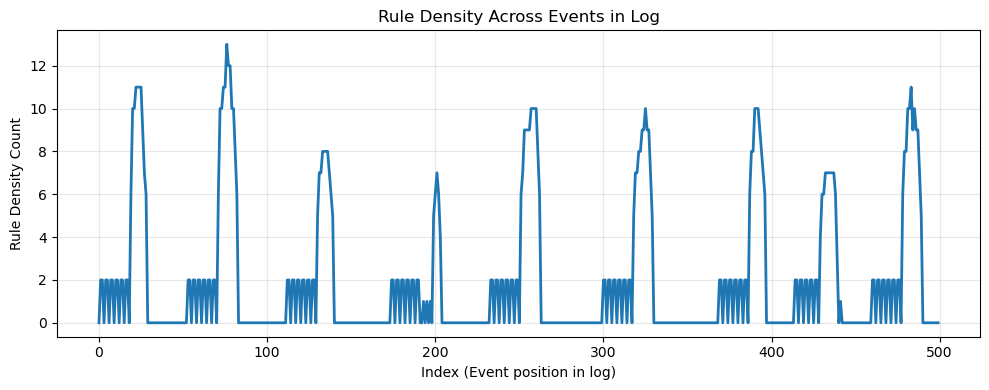

c:\Users\tomho\anaconda3\envs\tsrdWinter2025\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


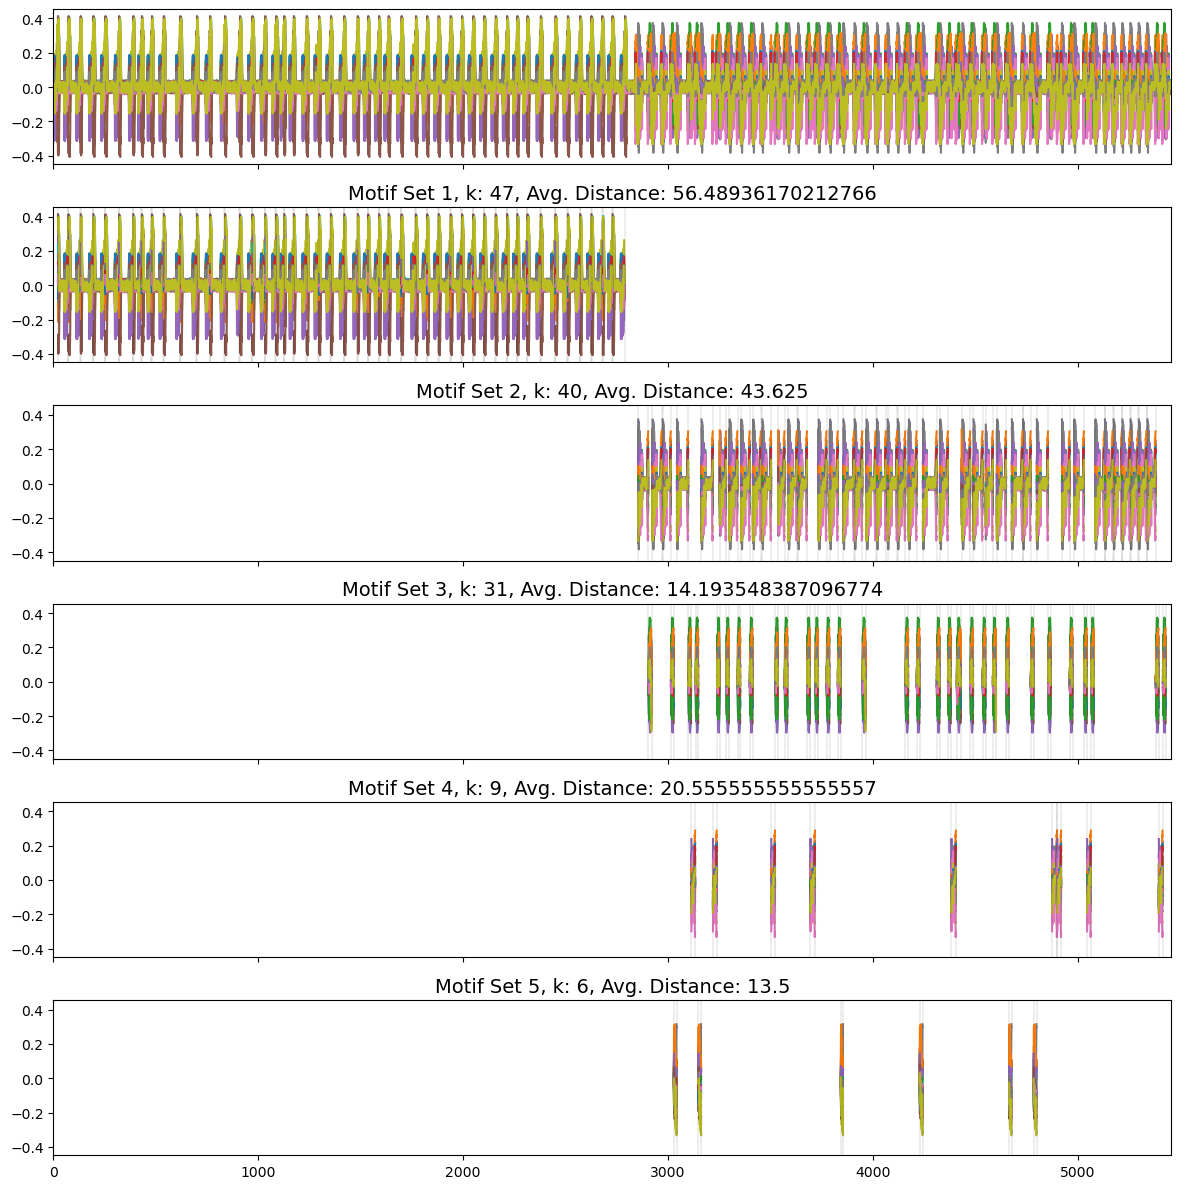

In [23]:
##################
##### Step 2 #####
##################

# Extend until the app changes for the specific pattern and add as "lower_app_switch" and "upper_app_switch"
max_groups_df = grammar_util.app_switch_miner(log, maximum_density_groups_df, hierarchy_columns_app_switch)
app_switch_mining_time = time.time()

lower_app_switches = max_groups_df["lower_app_switch"].tolist()
upper_app_switches = max_groups_df["upper_app_switch"].tolist()

# Mine the similar paths up and down until an app switch across discovered patterns is found
result_df = grammar_util.similar_path_up_down(
    df=log,
    max_groups_df=max_groups_df,
    start_indices=lower_app_switches,
    end_indices=upper_app_switches,
    cols=hierarchy_columns_app_switch,
    min_pairs=len(lower_app_switches)*app_switch_similarity_threshold, # At least 75% of the patterns should be similar in path
)


# build list of all valid index ranges
valid_indices = []

# Include additional safety margin from pattern switch
range_sum = 0
max_safety_margin = 0
for _, row in result_df.iterrows():
    # Set the safety margin as the distance between the pattern switches & apply factor to extend based on safety concern
    safety_margin = (int(row['upper_pattern_switch']) - int(row['lower_pattern_switch']))*safety_margin_factor
    if safety_margin > max_safety_margin:
        max_safety_margin = safety_margin
    valid_indices.extend(range(max(0, int(row['lower_pattern_switch'])-safety_margin),
                            min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1)))
    range_distance =  min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1) - max(0, int(row['lower_pattern_switch'])-safety_margin)

# Generate Extended with all margins as list as well
max_groups_df['ext_group_list'] = max_groups_df.apply(lambda row: list(range(row['lower_pattern_switch'], row['upper_pattern_switch'] + 1)), axis=1)

# Convert the valid indices to a set to remove duplicates
valid_indices_set = set(valid_indices)
print(f"Total Included Range Length: {len(valid_indices_set)} of {len(log)}")
print(f"Percentage of Log Included: {len(valid_indices_set)/len(log)*100:.2f}%")

log_path_extension_time = time.time()

# filter log to include only those indices
filtered_log = log.loc[log.index.intersection(valid_indices)].copy()

# optionally, keep the original index as a column for traceability
filtered_log['original_index'] = filtered_log.index
filtered_log.reset_index(drop=True, inplace=True)

##################
##### Step 3 #####
##################

# Encode the filtered log
if encoding_method == 1:
    print("Using Word2Vec based encoding for UI Log")
    filtered_log_encoded = valmod_util.encode_word2vec(uiLog=filtered_log, 
                                                       orderedColumnsList=hierarchy_columns, 
                                                       vector_size=token_based_vector_size,
                                                       completeCorpusLog=log)
    column_identifier = 'w2v_'
elif encoding_method == 2:
    print("Using Hierarchical based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=1)
    column_identifier = 'tuple:id'
elif encoding_method == 3:
    print("Using Co-Occurrance based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=2)
    column_identifier = 'tuple:id'
else:
    raise ValueError("Invalid encoding method selected. Choose 1, 2, or 3.")

print("Parts of the log that are retained after filtering based on pattern switches and safety margins:")
grammar_util.plot_density_curve_with_index_set(log, valid_indices_set, column_name="rule_density_count")
df_filtered_for_plotting = filtered_log.reset_index(drop=True)
print("Rule Density Curve of first 500 Events before Filtering:")
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
print("Rule Density Curve of first 500 Events after Filtering:")
grammar_util.plot_density_curve(df_filtered_for_plotting, range_low=0, range_high=min(500, len(df_filtered_for_plotting)))

# Reduce the data to an ordered time series for locomotif
filtered_columns_reduced_log = filtered_log_encoded.filter(like=column_identifier)

# Optional: Normalization
ts = (filtered_columns_reduced_log - np.mean(filtered_columns_reduced_log, axis=None)) / np.std(filtered_columns_reduced_log, axis=None)

##########################################################
##### Variable Length Motif Discovery with LOCOmotif #####
##########################################################

# Calculate length statistics:
# l_min = Grammer Rule Density Length Mean - Std Dev
# l_max = Safety Margin from App switch analysis
l_min = max(5,maximum_density_groups_df["length"].mean() - maximum_density_groups_df["length"].std())
l_max = max_safety_margin

# Variable Length Motif Discovery >> Using the low from the GRAMMAR as l_min, Using the security margin from app switch as l_max
motif_sets = locomotif.apply_locomotif(filtered_columns_reduced_log, l_min=l_min, l_max=l_max, rho=rho_LoCoMotif)
locomotif_discovery_time = time.time()

# Plotting with adjusted locomotif visualization (utils)
fig, ax = visualize.plot_motif_sets(series=filtered_columns_reduced_log.values,
                                    motif_sets=motif_sets, 
                                    max_plots=5,
                                    legend=False)
plt.show()

**STEP 4: Grammer-Motif Alignment and Candidate Extraction**

Identify overlap between LOCOmotif and Re-Pair motifs to ensure that by the filtering step no additional motifs are inserted

In [24]:
blocks = []

for cluster_set in motif_sets:# Efficient slicing instead of isin()
    for cluster_motif in cluster_set[1:]:
        for motif in cluster_motif:
            
            start_of_discovered_motif = motif[0]
            end_of_discovered_motif = motif[1]
            length_of_discovered_motif = end_of_discovered_motif - start_of_discovered_motif
            motif_original_start_index = filtered_log.loc[start_of_discovered_motif, "original_index"]
            # print(f"Motif Start Index: {start}, Motif Length: {end}")
            # print(f"Motif Original Start Index in Full Log: {motif_original_start_index}")
            try:
                block = pd.DataFrame({
                    "original_df_range": [list(range(motif_original_start_index, motif_original_start_index+length_of_discovered_motif))],
                    "cluster_id": [cluster_set[0]],
                    "original_df_case_ids": [log.loc[motif_original_start_index:motif_original_start_index+length_of_discovered_motif, "case:concept:name"].tolist()],
                    "motif_length": length_of_discovered_motif
                })
            except KeyError as ke:
                block = pd.DataFrame({
                    "original_df_range": [list(range(motif_original_start_index, motif_original_start_index+length_of_discovered_motif))],
                    "cluster_id": [cluster_set[0]],
                    "original_df_case_ids": [log.loc[motif_original_start_index:motif_original_start_index+length_of_discovered_motif, "caseid"].tolist()],
                    "motif_length": length_of_discovered_motif
                })
            blocks.append(block)
  
result_mapped_to_original_index = pd.concat(blocks, ignore_index=True)

result_mapped_to_original_index = grammar_util.mark_overlaps_grammer_locomotif_indexed(result_mapped_to_original_index, max_groups_df, col_df1="original_df_range", col_df2="ext_group_list")
total_end_time = time.time()

**Evaluation on candidates**

Final evaluation on the discovery with total (not seperatey by cluster > see Step 9)
- Recall
- Precision
- F1-score
- Overlap Rates

Final Evaluation of Discovered Motifs against Ground Truth:
Considering **all** discovered motifs from LOCOmotif without filtering step
tp: 96.000
fp: 51.000
fn: 4.000
intersection_ratio: 0.567
intersection_abs: 14.599
undercount_ratio: 0.568
undercount_abs: 26.000
over_detection_ratio: 0.433
over_detection_abs: 20.687

Precision: 0.653, Recall: 0.960, F1: 0.777

Final Evaluation of Discovered Motifs against Ground Truth:
Considering only those motifs that were also identified by Grammar Based Discovery
tp: 96.000
fp: 30.000
fn: 4.000
intersection_ratio: 0.519
intersection_abs: 15.563
undercount_ratio: 0.598
undercount_abs: 27.850
over_detection_ratio: 0.481
over_detection_abs: 23.873
Precision: 0.762, Recall: 0.960, F1: 0.850


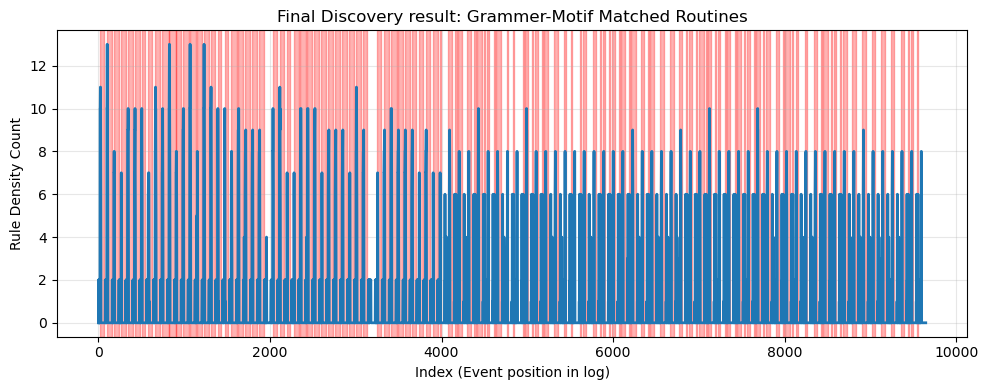

,motif,caseid,average_discovered_motif_length,precision,recall,f1,tp,fp,fn,required_total
0,RT,"[81, 69, 60, 76, 80, 82, 59, 61, 68, 86, 66, 7...",37.160000,0.641026,1.00,0.781250,50,28,0.0,50.0
1,SR,"[47, 24, 41, 43, 46, 23, 21, 20, 29, 26, 44, 3...",56.391304,0.978723,0.92,0.948454,46,1,4.0,50.0
2,UNMAPPED,-,0.000000,0.000000,0.00,0.000000,30,0,0.0,NaN


In [25]:
#########################################
#### Discovery before Grammer Filter ####
#########################################

print("Final Evaluation of Discovered Motifs against Ground Truth:")
print("Considering **all** discovered motifs from LOCOmotif without filtering step")

final_discovery_result = grammar_util.evaluate_motifs(result_mapped_to_original_index["original_df_range"], ground_truth, overlap_threshold)

overlap_table = final_discovery_result["overlap_table"]         # DataFrame for inspection
tp, fp, fn = final_discovery_result["tp"], final_discovery_result["fp"], final_discovery_result["fn"]
for key, value in final_discovery_result.items():
    if key != "overlap_table" and key != "matched_pairs":
        print(f"{key}: {value:.3f}")

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

print("\nFinal Evaluation of Discovered Motifs against Ground Truth:")
print("Considering only those motifs that were also identified by Grammar Based Discovery")

########################################
#### Discovery after Grammer Filter ####
########################################

# Filter the result to only include clusters with grammar motif matches

motif_df = result_mapped_to_original_index[
    result_mapped_to_original_index["grammer_motif_match"] == True
].copy()

motif_df = motif_df.reset_index(drop=True)   # index = motif_id = 0..M-1

# Call evaluate_motifs with the aligned motif_df
final_discovery_result = grammar_util.evaluate_motifs(
    motif_df["original_df_range"],
    ground_truth,
    overlap_threshold
)

overlap_table = final_discovery_result["overlap_table"]         # DataFrame for inspection
tp, fp, fn = final_discovery_result["tp"], final_discovery_result["fp"], final_discovery_result["fn"]
for key, value in final_discovery_result.items():
    if key != "overlap_table" and key != "matched_pairs":
        print(f"{key}: {value:.3f}")

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


# ---- Plotting the results ---- 

plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in result_mapped_to_original_index[result_mapped_to_original_index["grammer_motif_match"] == True]["original_df_range"].to_list():
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Final Discovery result: Grammer-Motif Matched Routines")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Calculating the results per Cluster ----
cluster_based_evaluation_df = grammar_util.join_discovery_with_ground_truth(final_discovery_result, ground_truth, motif_df)
if isSmartRPA2025: 
    # For Smart RPA 2025, we have case IDs in the format "motif[n]_caseid" in the ground_truth, which is the motif id in the Leno logs
    cluster_based_evaluation_df["motif"] = cluster_based_evaluation_df["motif_number"]
motif_res = grammar_util.motif_level_metrics(cluster_based_evaluation_df)
motif_purity = grammar_util.purity_per_two_columns(cluster_based_evaluation_df, cluster_by_col="motif", purity_col_name="cluster_id")

cluster_res = grammar_util.cluster_level_metrics(cluster_based_evaluation_df)
cluster_purity = grammar_util.purity_per_two_columns(cluster_based_evaluation_df, cluster_by_col="cluster_id", purity_col_name="motif")

motif_res

**Execution Time Results**

Compile execution times

In [26]:
# The times that are necessary to execute the discovery steps
# Works only if executed in sequence as above and with ">> Run All" cells 
print(f"--- Timing Summary (in seconds) {leno_file_name}---")
print(f"Total Execution Time: {total_end_time - total_start_time:.3f} seconds")
print(f"Re-Pair Time: {repair_time - total_start_time:.3f} seconds")
print(f"Density Count Time: {density_count_time - repair_time:.3f} seconds")
print(f"Max Density Groups Time: {max_density_groups_time - density_count_time:.3f} seconds")
print(f"App Switch Mining Time: {log_path_extension_time - app_switch_mining_time:.3f} seconds")
print(f"LOCOmotif Discovery Time: {locomotif_discovery_time - log_path_extension_time:.3f} seconds")

--- Timing Summary (in seconds) 202511_SR_RT_plus_extended.csv---
Total Execution Time: 115.320 seconds
Re-Pair Time: 2.870 seconds
Density Count Time: 4.116 seconds
Max Density Groups Time: 0.096 seconds
App Switch Mining Time: 0.182 seconds
LOCOmotif Discovery Time: 100.934 seconds
